In [1]:
import pandas as pd
import os

# Load the dataset
os.chdir("..")
data_path = 'datasets'
df = pd.read_csv(os.path.join(data_path, 'wine_quality_transformed.csv'), index_col=0)

# Display basic information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 998 entries, 0 to 997
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   country_encoded    998 non-null    int64  
 1   points_scaled      998 non-null    float64
 2   description_clean  998 non-null    object 
 3   variety_encoded    998 non-null    int64  
 4   text_length        998 non-null    int64  
 5   price_log          998 non-null    float64
 6   price_scaled       998 non-null    float64
dtypes: float64(3), int64(3), object(1)
memory usage: 62.4+ KB


In [2]:
df

,country_encoded,points_scaled,description_clean,variety_encoded,text_length,price_log,price_scaled
0,3,0.354598,good dry creek zin robust dry spicy really get...,104,27,3.258097,-0.136111
1,0,-1.131082,herbaceous character make seem rather thin sof...,8,15,3.044522,-0.493754
2,3,-1.131082,little simple easy wealth raspberry strawberry...,77,15,2.995732,-0.575456
3,3,0.057462,dry farmed vineyard treated wild yeast minimal...,61,24,3.663562,0.542865
4,3,0.948870,site near annapolis show preponderance dark gr...,66,20,4.143135,1.345938
...,...,...,...,...,...,...,...
993,0,-0.239674,made using selection fruit sourced bank serein...,15,17,3.583519,0.408828
994,2,-1.725354,quite green also raisiny really compute seeing...,72,26,2.944439,-0.661349
995,3,1.543143,mountain fruit key understanding cab meant uni...,12,34,4.454347,1.867083
996,1,0.057462,hat zonin family among first offer viognier so...,100,24,2.772589,-0.949123


In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Define max vocabulary size & sequence length
vocab_size = 5000  # Choose based on dataset size
maxlen = 100  # Max words per sequence

# Tokenize text descriptions
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(df["description_clean"])

# Convert text to sequences & pad them to ensure equal length
X_text = tokenizer.texts_to_sequences(df["description_clean"])
X_text = pad_sequences(X_text, maxlen=maxlen, padding="post")


2025-02-05 12:27:08.493919: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-05 12:27:08.517732: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738758428.542234  429819 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738758428.550437  429819 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-05 12:27:08.575713: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [4]:
from tensorflow.keras.utils import to_categorical

# Convert integer labels to one-hot encoding
y = to_categorical(df["country_encoded"])  # Converts [0,1,2,3] → [[1,0,0,0], [0,1,0,0], ...]

# Check shape
print("Updated y shape:", y.shape)  # Expected: (num_samples, 4)


Updated y shape: (998, 4)


In [5]:
from tensorflow.keras import layers, Sequential
from tensorflow.keras.optimizers import Adam

# Define parameters
vocab_size = 5000  # Adjust based on your dataset
maxlen = 100  # Maximum sequence length
embedding_size = 128  # Dimension of word embeddings

def build_model_nlp():
    model = Sequential([
        layers.Embedding(input_dim=vocab_size+1, input_length=maxlen, output_dim=embedding_size, mask_zero=True),
        layers.Conv1D(10, kernel_size=10, padding='same', activation="relu"),
        layers.Conv1D(10, kernel_size=8, padding='same', activation="relu"),
        layers.Flatten(),
        layers.Dense(30, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(4, activation='softmax')  # Ensure output matches number of classes
    ])

    model.build(input_shape=(None, maxlen))  # Explicitly define input shape
    model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=1e-5), metrics=['accuracy'])
    return model

# Build the model and display the summary
model_nlp = build_model_nlp()
model_nlp.summary()


/home/jonnyoh/.pyenv/versions/3.12.4/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
W0000 00:00:1738758433.223342  429819 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/jonnyoh/.pyenv/versions/3.12.4/lib/python3.12/site-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 128)       │       640,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 100, 10)        │        12,810 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 100, 10)        │           810 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 30)             │        30,030 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 683,902 (2.61 MB)

 Trainable params: 683,902 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
from sklearn.model_selection import train_test_split

# First, split into training + temp (validation + test)
X_train, X_test, y_train, y_test = train_test_split(X_text, y, test_size=0.3, random_state=42)


In [7]:
# Train with separate validation set
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history = model_nlp.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping] # Use validation set instead of test set
)


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.4178 - loss: 1.3815 - val_accuracy: 0.6233 - val_loss: 1.3750
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5057 - loss: 1.3721 - val_accuracy: 0.6433 - val_loss: 1.3635
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5587 - loss: 1.3601 - val_accuracy: 0.6433 - val_loss: 1.3433
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5842 - loss: 1.3396 - val_accuracy: 0.6433 - val_loss: 1.3116
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6131 - loss: 1.3093 - val_accuracy: 0.6433 - val_loss: 1.2729
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6167 - loss: 1.2673 - val_accuracy: 0.6433 - val_loss: 1.2303
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6151 - loss: 1.2247 - val_accuracy: 0.6433 - val_loss: 1.1850
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5900 - loss: 1.2089 - val_accuracy: 0.6433 - v

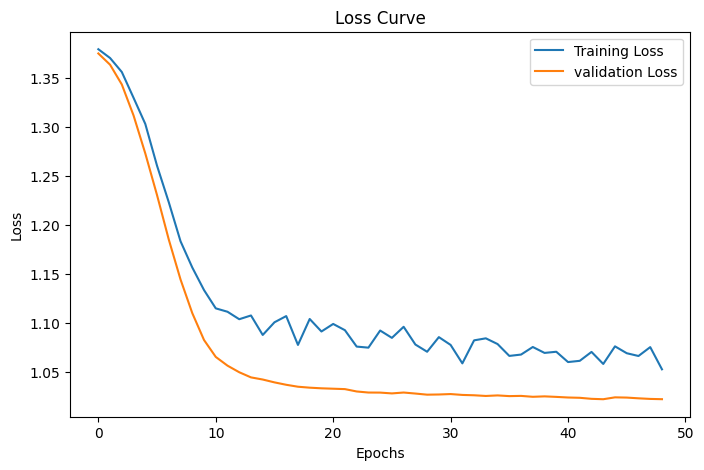

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")
plt.show()

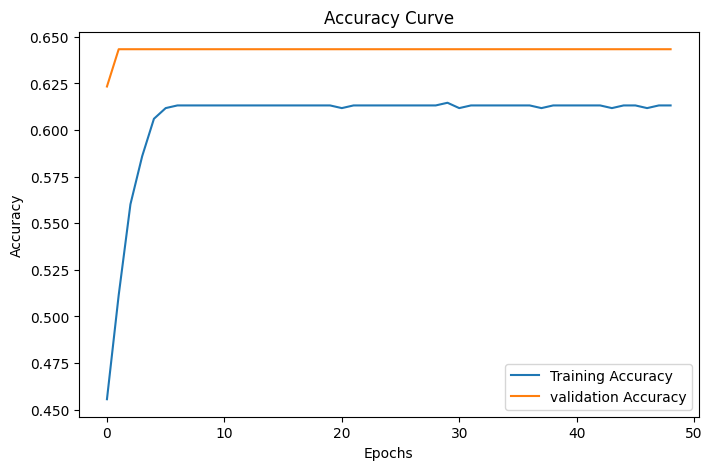

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curve")
plt.show()